In [3]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

# Quantum Binary Neural Network or BNN

This notebook is the replication of the article [Training and Meta-Training Binary Neural Networks with quantum computing](http://delivery.acm.org/10.1145/3340000/3330953/p1674-fawaz.pdf?ip=150.161.2.202&id=3330953&acc=ACTIVE%20SERVICE&key=344E943C9DC262BB%2ECE287F0A0786CB60%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1568896858_67f5ed409089b2de442af612b6393a9e)


A binary neural neural network is the type of neural network where its weights and activations are binary,
usually $ \pm 1$.
In this [work](http://delivery.acm.org/10.1145/3340000/3330953/p1674-fawaz.pdf?ip=150.161.2.202&id=3330953&acc=ACTIVE%20SERVICE&key=344E943C9DC262BB%2ECE287F0A0786CB60%2E4D4702B0C3E38B35%2E4D4702B0C3E38B35&__acm__=1568896858_67f5ed409089b2de442af612b6393a9e) the authors proposed a simple implementation of a quantum BNN. Where its inputs are binary strings and it performs the task of binary classification. 

First, the authors have defined the format of the inputs and how the labels were to be assigned. For simplicity, the authors have only defined two problems for classification where, given a binary string $x_0x_1x_3$ its labels will be defined as:

For problem 1:
$$
y  = sign(x_3x_1 + x_2) 
$$


For problem 2:
$$
y = sign(x_1 + x_3 + x_2) 
$$

After making the definitions, the authors have presented how such a system could be implemented in a quantum chip, using quantum gates.

First they had to decide how to implement the $sign$ function. Which they opted to implement another version of the function: $sign^2(x)$ or the majority function.  Which returns $1$ whenever at least a certain percentage of the binary string is set to $1$. The followonig image shows the implementation of the classical majority function . 

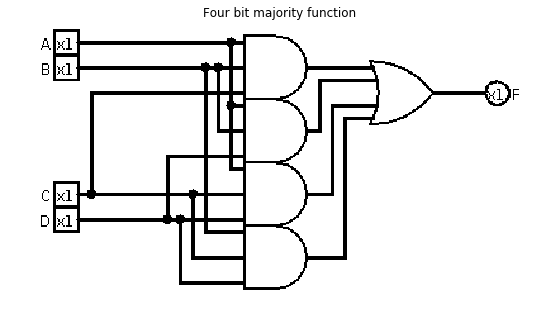

In [6]:
image = cv2.imread("images/Four_Bit_Majority_Circuit.png")
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.set_title("Four bit majority function")
ax.imshow(image)
ax.set_axis_off()

The figure above was taken from [here](https://en.wikipedia.org/wiki/Majority_function).

As it can be observed, the circuit recieves a four bit string as input. 
Then it tests multiple conbinations of the entries to verify its majority condition. 
In this case it is verifying if at least  $ > 50\%$ of the entry is set to $1$. 

The circuit can be modified to verify if exactly $50\%$ of the entry is set to one.
For the case of this $4$-bit string it would be necessary to use $\binom{4}{2}$ $AND$ gates and one $OR$ gate.

## Implementing the quantum version of the sign function

Before we get into the details of the  Quantum BNN implementation it is necessary to think about how to implement the sign functon. 

First the reversible $AND$ gate can be implemented using the $CNOT$ gate or $Toffoli$. 
A quick recall of how the $Toffoli$ operates over the states when used as a $AND$ reversible gate:
$$
Toffoli|x\rangle|y\rangle|0\rangle = |x\rangle|y\rangle|x\wedge y\rangle
$$

To build the $OR$ reversible gate we can take advantage of DeMorgan's law. 
$$
Toffoli\left( X\otimes X |x\rangle|y\rangle|1\rangle \right) = Toffoli |\neg x\rangle|\neg y\rangle|1\rangle
$$

Which leads to:
$$
|\neg x\rangle|\neg y\rangle|\neg(\neg x \wedge \neg y)\rangle = |\neg x\rangle|\neg y\rangle|( x \vee y)\rangle
$$
Then the application of the NOT gates can be reversed.
The quantum circuit for those operations will be as the ws:


In [11]:
qub = QuantumRegister(3,'q')
cb = ClassicalRegister(1,'c')
qc = QuantumCircuit(qub,cb)

qc.x(qub[0])
qc.x(qub[1])

# Setting ancilary qubit to 1
qc.x(qub[2])

qc.ccx(qub[0],qub[1],qub[2])

# Reversing the aplication of the not gates
qc.x(qub[0])
qc.x(qub[1])
qc.draw()

However, for a three qubit entry the circuit would have be a little bit different.
But as it has been said, the number of comparisons necessary to implement a quantum majority function would have to be $\binom{2^n}{k}$. Where $2^n$ represents the size of the entry and $k$ represents the number of qubits we desire to be set to $1$ in the string.

In [17]:
n_input = 3
n_ancila = n_input+2

qub = QuantumRegister(n_input+n_ancila,'q')
cb = ClassicalRegister(1,'c')
qc = QuantumCircuit(qub,cb)

# Making the AND gate comparisons
# Given the entry |xyz>|00000>
# Making |xyz>|(x and y)0000>
qc.ccx(qub[0],qub[1],qub[3])

# Making |xyz>|(x and y)(x and z)000>
qc.ccx(qub[0],qub[2],qub[4])
# Making |xyz>|(x and y)(x and z)(y and z)00>
qc.ccx(qub[1],qub[2],qub[5])

# Aplying OR gate in the outputs of the previous applications
qc.x(qub[3])
qc.x(qub[4])
qc.x(qub[5])
# Setting OR qubits' ancilary gate to |1>
qc.x(qub[6])
qc.x(qub[7])

# Making |xyz>|(x and y)(x and z)(y and z)((not (x and y)) and (not (x and z)))0>
qc.ccx(qub[3],qub[4],qub[6])
# Making |xyz>|(x and y)(x and z)(y and z)(not(not (x and y)) and (not (x and z)) and (not (y and z)))>
# Resulting in (x and y)(x and z)(y and z)((x and y) or (x and z) or (y and z))
qc.ccx(qub[5],qub[6],qub[7])

qc.draw()
